In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Jun 27 14:05:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
pip install livelossplot

# **5 Breeds**

## **Import Libraries**

In [ ]:
import os 
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import tensorflow as tf
from collections import Counter
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten, Input, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.regularizers import l2
from keras.models import Model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import RMSprop, SGD
from keras.callbacks import History, ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from keras.optimizers import RMSprop
from keras.constraints import unit_norm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from livelossplot.inputs.keras import PlotLossesCallback
%matplotlib inline

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
#set the training path
training_path='/content/drive/MyDrive/Formation_Machine_Learning/P6/data/resized_images/training_data'
#set the validation path
validation_path='/content/drive/MyDrive/Formation_Machine_Learning/P6/data/resized_images/validation_data'
#set the test path
test_path='/content/drive/MyDrive/Formation_Machine_Learning/P6/data/resized_images/test_data'

# **Data preparation**

## Create Datasets (Inputs & Labels)

In order to get seperatly the feautres(image arrays) and the labels, we have build a small function that do the following:

- fetches the images arrays from a specific folder (training, validation, test)

- convert image inputs to floats

- rescale the images and then store them into a a list of arrays  along with the labels

In [ ]:
def create_dataset(folder_path,breed_classes):
  
  image_arrays=[]
  image_classes=[]

  for breed in os.listdir(folder_path):
    if breed in breed_classes:
      breed_path=os.path.join(folder_path,breed)
      for img in os.listdir(breed_path):
        
        image=cv2.imread(os.path.join(breed_path,img),cv2.IMREAD_UNCHANGED)
        image = image.astype('float64')
        image /= 255

        image_arrays.append(image)
        image_classes.append(breed)


  return image_arrays , image_classes



In [ ]:
breeds=['chow','collie','cairn','dhole','dingo']

In [ ]:
img_data, class_names=create_dataset(training_path, breeds)

In [ ]:
img_data_val, class_names_val=create_dataset(validation_path, breeds)

In [ ]:
img_data_test, class_names_test=create_dataset(test_path, breeds)

Next, we prepare the labels as a list of label encoded inputs from a **breed list** that we chose 

In [ ]:
target_dict={k: v for v, k in enumerate(np.unique(class_names))}
target_val=  [target_dict[class_names[i]] for i in range(len(class_names))]

In [ ]:
target_dict_val={k: v for v, k in enumerate(np.unique(class_names_val))}
target_val_val=  [target_dict_val[class_names_val[i]] for i in range(len(class_names_val))]

In [ ]:
target_dict_test={k: v for v, k in enumerate(np.unique(class_names_test))}
target_val_test=  [target_dict_test[class_names_test[i]] for i in range(len(class_names_test))]

# **Build Baseline model**

## Training Model

In [8]:
def create_cnn_model(activation_fn='relu', kernel_s=(3,3), padding='same', drop_rate=0.25,optimizer='adam'):

  #initialize the Sequential model
  model=Sequential()
  #First Conv Layer
  model.add(Conv2D(32, kernel_size=kernel_s, padding=padding, activation='relu',input_shape=(224,224,3)))
  
  #getting the pooling method
  '''def get_pool(poolling):
    if pool=='max':
      return MaxPooling2D()
    else:
      return AveragePooling2D()'''

  #adding the pooling method
  #model.add(get_pool(poolling))
  model.add(MaxPooling2D())

  #Second Conv Layer
  model.add(Conv2D(64, kernel_size=kernel_s, padding=padding, activation=activation_fn))
  #model.add(get_pool(poolling))
  model.add(MaxPooling2D())

  #third Conv Layer
  model.add(Conv2D(128, kernel_size=kernel_s, padding=padding, activation=activation_fn))
  #model.add(get_pool(poolling))
  model.add(MaxPooling2D())

  #fourth Conv Layer with a dropout layer to simplify the model
  model.add(Conv2D(128, kernel_size=kernel_s, padding=padding, activation=activation_fn))
  #model.add(get_pool(poolling))
  model.add(MaxPooling2D())
  model.add(Dropout(drop_rate))

  #Combine the CNN network with the ANN model
  model.add(Flatten())
  model.add(Dense(512,activation=activation_fn))
  model.add(Dropout(drop_rate))
  model.add(Dense(5,activation='softmax'))

  model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])


  
  return model


In [ ]:
model_keras=KerasClassifier(build_fn=create_cnn_model, epochs=1000, batch_size=20)

In [ ]:
history_keras = model_keras.fit(x=np.array(img_data, np.float64), y=tf.keras.utils.to_categorical(np.array(target_val, dtype=np.float64)),steps_per_epoch=553//20, epochs=1000, verbose=1, 
                          validation_data=(np.array(img_data_val, dtype=np.float64),tf.keras.utils.to_categorical(np.array(target_val_val, dtype=np.float64))), validation_steps=len(img_data_val) // 20, callbacks=[History(),
               ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/5_breeds/' + 'data_keras_5_breeds', monitor='val_accuracy', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True, verbose=1)])


Epoch 1/1000
27/27 [==============================] - 2s 42ms/step - loss: 1.8150 - accuracy: 0.2381 - val_loss: 1.6027 - val_accuracy: 0.2500

Epoch 00001: val_accuracy improved from -inf to 0.25000, saving model to /content/drive/MyDrive/Formation_Machine_Learning/P6/5_breeds/data_keras_5_breeds
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Formation_Machine_Learning/P6/5_breeds/data_keras_5_breeds/assets
Epoch 2/1000
27/27 [==============================] - 1s 25ms/step - loss: 1.6079 - accuracy: 0.2157 - val_loss: 1.6037 - val_accuracy: 0.2500

Epoch 00002: val_accuracy did not improve from 0.25000
Epoch 3/1000
27/27 [==============================] - 1s 25ms/step - loss: 1.6054 - accuracy: 0.2338 - val_loss: 1.5960 - val_accuracy: 0.2500

Epoch 00003: val_accuracy did not improve from 0.25000
Epoch 4/1000
27/27 [==============================] - 1s 25ms/step - loss: 1.5924 - accuracy: 0.2991 - val_loss: 1.6007 - val_accuracy: 0.2500

Epoch 00004: val_accuracy did not i

### Evaluate model

In [ ]:
model_keras.score(x=np.array(img_data_test, np.float64), y=tf.keras.utils.to_categorical(np.array(target_val_test, dtype=np.float64)))

7/7 [==============================] - 0s 12ms/step - loss: 4.9434 - accuracy: 0.2520


0.25196850299835205

regarding the test set, in terms of loss and accuracy we did not perform as well as we want with:

- **test_accuracy**: 0.25

- **test_loss**: 4.9

No handles with labels found to put in legend.


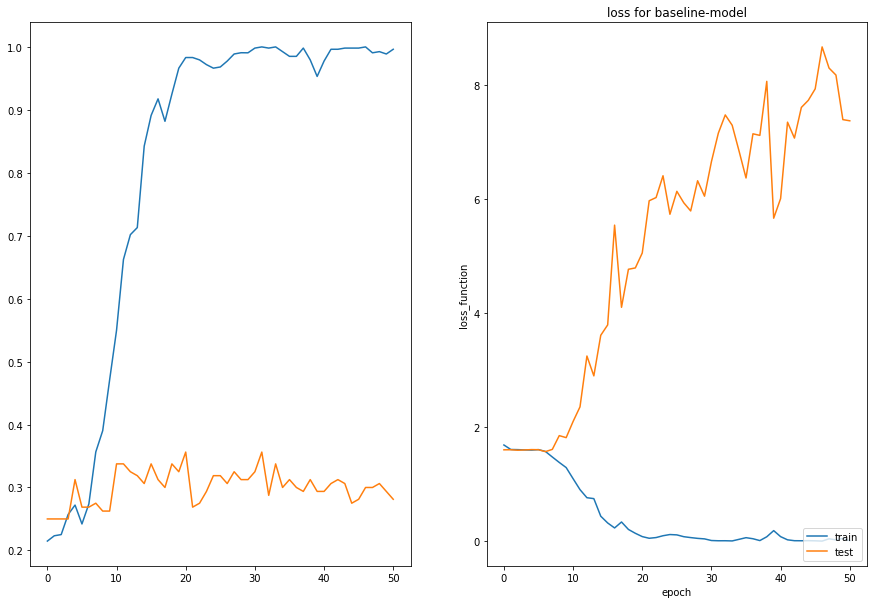

In [ ]:
f = plt.figure(figsize=(15, 10))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(history_keras.history['accuracy'],label='train')
ax1.plot(history_keras.history['val_accuracy'],label='test')
plt.title('accuracy for baseline-model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')

ax2.plot(history_keras.history['loss'],label='train')
ax2.plot(history_keras.history['val_loss'],label='test')
plt.title('loss for baseline-model')
plt.ylabel('loss_function')
plt.xlabel('epoch')
plt.legend(loc='lower right')

As we can see in our case, overfitting reveals itself in two aspects: 

- the figure on the left shows that,the accuracy of your training dataset, the dataset used to “teach” the model, is greater than our validation accuracy

- on the right side, we are comparing the loss values in both sets. the model has a low error in the training set and a higher error in the validation set.

We still not in the worst case scenario though, as the general rule states *Start by overfitting the model, then take measures against overfitting* 

# **Fixing Overfitting**

To face this kind of issue, We are going to follow these steps in order to improve our validation accuracy:

- Procede with a tuning of our model hyper-parameters

- Add more data using the data augmentation technique


## **Tuning Model Hyper-parameters**

We are going to use the Randomized grid search technique to fine tune our model



### Randomized Grid Search

In [ ]:
rand_model=KerasClassifier(build_fn=create_cnn_model, epochs=1000, batch_size=20)

We are focusing on some important keys in our build-in function: 

- Activation function

- the kernel size

- padding method

- optimizer technique

- dropout regularization

In [ ]:
param_rand = {'activation_fn': ['tanh','relu'],
              'kernel_s': [(3,3),(4,4),(5,5)],
              'padding':['same','valid'],
              'optimizer':['SGD', 'RMSprop', 'Adagrad','adam'],
              'drop_rate':[0.1,0.2,0.3,0.4]}

In [ ]:
rand=RandomizedSearchCV(estimator=rand_model, param_distributions=param_rand, n_iter=15, cv=3, verbose=1)

In [ ]:
res=rand.fit(X=np.array(img_data, np.float64), y=tf.keras.utils.to_categorical(np.array(target_val, dtype=np.float64)),steps_per_epoch=553//20, epochs=1000, verbose=1, 
                          validation_data=(np.array(img_data_val, dtype=np.float64),tf.keras.utils.to_categorical(np.array(target_val_val, dtype=np.float64))), validation_steps=len(img_data_val) // 20, callbacks=[History(),
               ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/5_breeds/' + 'data_keras_rand_5_breeds', monitor='val_accuracy', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True, verbose=1)])

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Epoch 43/1000
27/27 [==============================] - 1s 25ms/step - loss: 0.0221 - accuracy: 0.9863 - val_loss: 15.0302 - val_accuracy: 0.3250

Epoch 00043: val_accuracy did not improve from 0.41250
Epoch 44/1000
27/27 [==============================] - 1s 26ms/step - loss: 0.1337 - accuracy: 0.9818 - val_loss: 17.0950 - val_accuracy: 0.3375

Epoch 00044: val_accuracy did not improve from 0.41250
Epoch 45/1000
27/27 [==============================] - 1s 26ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 17.3432 - val_accuracy: 0.3438

Epoch 00045: val_accuracy did not improve from 0.41250
Epoch 46/1000
27/27 [==============================] - 1s 26ms/step - loss: 0.0169 - accuracy: 0.9965 - val_loss: 19.8632 - val_accuracy: 0.3625

Epoch 00046: val_accuracy did not improve from 0.41250
Epoch 47/1000
27/27 [==============================] - 1s 26ms/step - loss: 0.0308 - accuracy: 0.9927 - val_loss: 19.2

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 35.0min finished


Epoch 1/1000
27/27 [==============================] - 2s 47ms/step - loss: 1.6402 - accuracy: 0.2196 - val_loss: 1.6181 - val_accuracy: 0.2625

Epoch 00001: val_accuracy did not improve from 0.41875
Epoch 2/1000
27/27 [==============================] - 1s 31ms/step - loss: 1.6048 - accuracy: 0.2763 - val_loss: 1.5873 - val_accuracy: 0.2688

Epoch 00002: val_accuracy did not improve from 0.41875
Epoch 3/1000
27/27 [==============================] - 1s 30ms/step - loss: 1.5747 - accuracy: 0.2854 - val_loss: 1.5737 - val_accuracy: 0.3000

Epoch 00003: val_accuracy did not improve from 0.41875
Epoch 4/1000
27/27 [==============================] - 1s 30ms/step - loss: 1.5729 - accuracy: 0.2751 - val_loss: 1.5709 - val_accuracy: 0.3187

Epoch 00004: val_accuracy did not improve from 0.41875
Epoch 5/1000
27/27 [==============================] - 1s 31ms/step - loss: 1.5427 - accuracy: 0.3512 - val_loss: 1.5581 - val_accuracy: 0.3562

Epoch 00005: val_accuracy did not improve from 0.41875
Epoch

In [ ]:
 print('Best score = {:.4f} using {}'.format(res.best_score_, res.best_params_))

Best score = 0.0921 using {'padding': 'valid', 'optimizer': 'Adagrad', 'kernel_s': (4, 4), 'drop_rate': 0.3, 'activation_fn': 'tanh'}


In [ ]:
rand.best_estimator_.score(x=np.array(img_data_test, np.float64), y=tf.keras.utils.to_categorical(np.array(target_val_test, dtype=np.float64)))

7/7 [==============================] - 1s 18ms/step - loss: 1.3496 - accuracy: 0.4646


0.4645669162273407

Hourra!!! :D 

We can see the huge impact of our fine tuning parameters on the test set evaluation. 

We have  made a big improvment on our metrics with an accuracy from **0.25** to **0.46** and test loss from **4.9** to **1.3** 

lets try to train again our model with the best parameters we got!

### Fitting with the best parameters

In [9]:
best_params={'padding': 'valid', 'optimizer': 'Adagrad', 'kernel_s': (4, 4), 'drop_rate': 0.3, 'activation_fn': 'tanh'}

In [10]:
best_model=create_cnn_model(**best_params)

In [ ]:
best_res=best_model.fit(x=np.array(img_data, np.float64), y=tf.keras.utils.to_categorical(np.array(target_val, dtype=np.float64)),steps_per_epoch=553//20, epochs=1000, verbose=1, 
                          validation_data=(np.array(img_data_val, dtype=np.float64),tf.keras.utils.to_categorical(np.array(target_val_val, dtype=np.float64))), validation_steps=len(img_data_val) // 20, callbacks=[History(),
               ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/5_breeds/' + 'data_keras_rand_5_breeds', monitor='val_accuracy', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True, verbose=1)])

Epoch 1/1000
27/27 [==============================] - 3s 53ms/step - loss: 1.6250 - accuracy: 0.2072 - val_loss: 1.6283 - val_accuracy: 0.1919

Epoch 00001: val_accuracy improved from -inf to 0.19186, saving model to /content/drive/MyDrive/Formation_Machine_Learning/P6/5_breeds/data_keras_rand_5_breeds
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Formation_Machine_Learning/P6/5_breeds/data_keras_rand_5_breeds/assets
Epoch 2/1000
27/27 [==============================] - 1s 31ms/step - loss: 1.6095 - accuracy: 0.2489 - val_loss: 1.5958 - val_accuracy: 0.2267

Epoch 00002: val_accuracy improved from 0.19186 to 0.22674, saving model to /content/drive/MyDrive/Formation_Machine_Learning/P6/5_breeds/data_keras_rand_5_breeds
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Formation_Machine_Learning/P6/5_breeds/data_keras_rand_5_breeds/assets
Epoch 3/1000
27/27 [==============================] - 1s 31ms/step - loss: 1.5963 - accuracy: 0.2850 - val_loss: 1.5898 - val_accur

### Evaluating the test set performance

In [ ]:
best_model.evaluate(x=np.array(img_data_test, np.float64), y=tf.keras.utils.to_categorical(np.array(target_val_test, dtype=np.float64)))

4/4 [==============================] - 0s 45ms/step - loss: 1.4020 - accuracy: 0.4724


[1.4020296335220337, 0.4724409580230713]

No handles with labels found to put in legend.


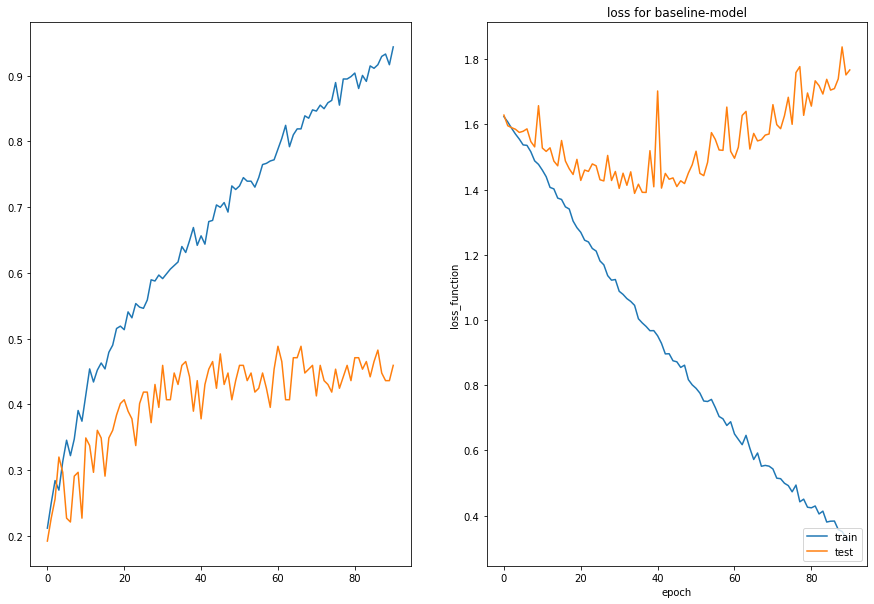

In [ ]:
f = plt.figure(figsize=(15, 10))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(best_res.history['accuracy'],label='train')
ax1.plot(best_res.history['val_accuracy'],label='test')
plt.title('accuracy for baseline-model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')

ax2.plot(best_res.history['loss'],label='train')
ax2.plot(best_res.history['val_loss'],label='test')
plt.title('loss for baseline-model')
plt.ylabel('loss_function')
plt.xlabel('epoch')
plt.legend(loc='lower right')

## **Data Augmentation Method**: Fitting the model with different data augmented features






In order to get the best result for our model, we are choosing a variety of data augmentation technique: 

- rescaled images: with no image modifying

- Horizontal and vertical shift

- Horizontal flip

- Vertical flip

- Rotation technique 

- A Mixing combination of data augmentation techniques

### **Rescaled data augmentation** 

In [ ]:
train_gen=ImageDataGenerator(rescale=1/255)
train_features=train_gen.flow_from_directory(training_path, classes=breeds, batch_size=20, target_size=(224,224))

Found 553 images belonging to 5 classes.


In [11]:
validation_gen=ImageDataGenerator(rescale=1/255)
aug_validation=validation_gen.flow_from_directory(validation_path,target_size=(224, 224),classes=['chow', 'collie','cairn','dhole','dingo'],
                              class_mode='categorical', batch_size=20, shuffle=False)

Found 172 images belonging to 5 classes.


In [ ]:
best_res=best_model.fit(train_features,steps_per_epoch=553//20, epochs=1000, verbose=1, 
                          validation_data=aug_validation, validation_steps=aug_validation.n// 20, callbacks=[History(),
               ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/5_breeds/' + 'data_5_breeds', monitor='val_accuracy', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True, verbose=1)])

Epoch 1/1000
27/27 [==============================] - 3s 97ms/step - loss: 0.9312 - accuracy: 0.6492 - val_loss: 1.2455 - val_accuracy: 0.5500

Epoch 00001: val_accuracy improved from -inf to 0.55000, saving model to /content/drive/MyDrive/Formation_Machine_Learning/P6/5_breeds/data_5_breeds
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Formation_Machine_Learning/P6/5_breeds/data_5_breeds/assets
Epoch 2/1000
27/27 [==============================] - 3s 97ms/step - loss: 0.8988 - accuracy: 0.6660 - val_loss: 1.2473 - val_accuracy: 0.5500

Epoch 00002: val_accuracy did not improve from 0.55000
Epoch 3/1000
27/27 [==============================] - 3s 94ms/step - loss: 0.9003 - accuracy: 0.6642 - val_loss: 1.2698 - val_accuracy: 0.5688

Epoch 00003: val_accuracy improved from 0.55000 to 0.56875, saving model to /content/drive/MyDrive/Formation_Machine_Learning/P6/5_breeds/data_5_breeds
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Formation_Machine_Learning/P6/5_bree

### **Horizontal and Vertical Shift Augmentation**

In [ ]:
shift_gen=ImageDataGenerator(width_shift_range=0.2,height_shift_range=0.2,
                             fill_mode='nearest',rescale=1/255)

In [ ]:
shifted_train=shift_gen.flow_from_directory(training_path, target_size=(224, 224),classes=['chow', 'collie','cairn','dhole','dingo'],
                              class_mode='categorical', batch_size=20)

Found 553 images belonging to 5 classes.


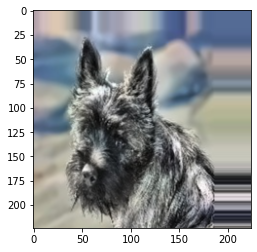

In [ ]:
plt.imshow(shifted_train.next()[0][0])

In [ ]:
result_shifted=best_model.fit(shifted_train, steps_per_epoch=553//20, epochs=1000, verbose=1,
                          validation_data=aug_validation, validation_steps=aug_validation.n //20,
                          callbacks=[History(),
               ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/5_breeds/' + 'shifted_data_5_breeds', monitor='val_accuracy', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True, verbose=1)
              ])

Epoch 1/1000
27/27 [==============================] - 7s 255ms/step - loss: 1.2311 - accuracy: 0.4972 - val_loss: 1.2628 - val_accuracy: 0.5375

Epoch 00001: val_accuracy improved from -inf to 0.53750, saving model to /content/drive/MyDrive/Formation_Machine_Learning/P6/5_breeds/shifted_data_5_breeds
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Formation_Machine_Learning/P6/5_breeds/shifted_data_5_breeds/assets
Epoch 2/1000
27/27 [==============================] - 7s 253ms/step - loss: 1.2171 - accuracy: 0.5385 - val_loss: 1.2737 - val_accuracy: 0.5188

Epoch 00002: val_accuracy did not improve from 0.53750
Epoch 3/1000
27/27 [==============================] - 7s 270ms/step - loss: 1.1459 - accuracy: 0.5403 - val_loss: 1.2674 - val_accuracy: 0.5188

Epoch 00003: val_accuracy did not improve from 0.53750
Epoch 4/1000
27/27 [==============================] - 7s 252ms/step - loss: 1.1785 - accuracy: 0.5553 - val_loss: 1.2926 - val_accuracy: 0.5250

Epoch 00004: val_accuracy d

### **Horizontal Flip Augmentation**

In [ ]:
hflip_gen=ImageDataGenerator(horizontal_flip=True,fill_mode='nearest',rescale=1/255)
hflipped_train=hflip_gen.flow_from_directory(training_path, target_size=(224, 224),classes=['chow', 'collie','cairn','dhole','dingo'],class_mode='categorical', batch_size=20)


Found 553 images belonging to 5 classes.


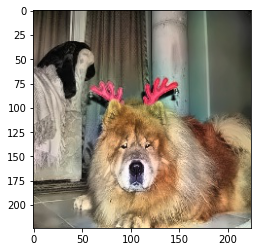

In [ ]:
plt.imshow(hflipped_train.next()[0][0])

In [ ]:
result_hflipped=best_model.fit(hflipped_train, steps_per_epoch=553//20, epochs=1000, verbose=1,
                          validation_data=aug_validation, validation_steps=aug_validation.n // 20,
                          callbacks=[History(),
               ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/5_breeds/' + 'hflipped_data_5_breeds', monitor='val_accuracy', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True, verbose=1)
              ])

Epoch 1/1000
27/27 [==============================] - 2s 90ms/step - loss: 0.9535 - accuracy: 0.6323 - val_loss: 1.2527 - val_accuracy: 0.5562

Epoch 00001: val_accuracy improved from -inf to 0.55625, saving model to /content/drive/MyDrive/Formation_Machine_Learning/P6/5_breeds/hflipped_data_5_breeds
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Formation_Machine_Learning/P6/5_breeds/hflipped_data_5_breeds/assets
Epoch 2/1000
27/27 [==============================] - 2s 87ms/step - loss: 0.9386 - accuracy: 0.6492 - val_loss: 1.2496 - val_accuracy: 0.5312

Epoch 00002: val_accuracy did not improve from 0.55625
Epoch 3/1000
27/27 [==============================] - 2s 88ms/step - loss: 0.9052 - accuracy: 0.6548 - val_loss: 1.2771 - val_accuracy: 0.5688

Epoch 00003: val_accuracy improved from 0.55625 to 0.56875, saving model to /content/drive/MyDrive/Formation_Machine_Learning/P6/5_breeds/hflipped_data_5_breeds
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Formation

### **Vertical Flip Augmentation**

In [ ]:
vflip_gen=ImageDataGenerator(vertical_flip=True,fill_mode='nearest',rescale=1/255)
vflipped_train=vflip_gen.flow_from_directory(training_path, target_size=(224, 224),classes=['chow', 'collie','cairn','dhole','dingo'],
                              class_mode='categorical', batch_size=20)

Found 553 images belonging to 5 classes.


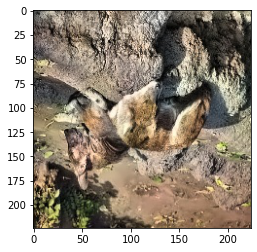

In [ ]:
plt.imshow(vflipped_train.next()[0][0])

In [ ]:
reslt_vflipped=best_model.fit(vflipped_train, steps_per_epoch=553//20, epochs=1000, verbose=1,
                          validation_data=aug_validation, validation_steps=aug_validation.n //20,
                          callbacks=[History(),
               ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/5_breeds/' + 'vflipped_data_5_breeds', monitor='val_accuracy', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True, verbose=1)
              ])

Epoch 1/1000
27/27 [==============================] - 2s 91ms/step - loss: 1.0746 - accuracy: 0.6004 - val_loss: 1.2839 - val_accuracy: 0.5375

Epoch 00001: val_accuracy improved from -inf to 0.53750, saving model to /content/drive/MyDrive/Formation_Machine_Learning/P6/5_breeds/vflipped_data_5_breeds
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Formation_Machine_Learning/P6/5_breeds/vflipped_data_5_breeds/assets
Epoch 2/1000
27/27 [==============================] - 2s 85ms/step - loss: 1.0757 - accuracy: 0.5854 - val_loss: 1.2645 - val_accuracy: 0.5625

Epoch 00002: val_accuracy improved from 0.53750 to 0.56250, saving model to /content/drive/MyDrive/Formation_Machine_Learning/P6/5_breeds/vflipped_data_5_breeds
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Formation_Machine_Learning/P6/5_breeds/vflipped_data_5_breeds/assets
Epoch 3/1000
27/27 [==============================] - 2s 87ms/step - loss: 1.0698 - accuracy: 0.5779 - val_loss: 1.2659 - val_accuracy: 0.5

### **Rotation Augmentation**

In [12]:
rotation_gen=ImageDataGenerator(rotation_range=90,fill_mode='nearest',rescale=1/255)
rotation_train=rotation_gen.flow_from_directory(training_path, target_size=(224, 224),classes=['chow', 'collie','cairn','dhole','dingo'],
                              class_mode='categorical', batch_size=20)

Found 553 images belonging to 5 classes.


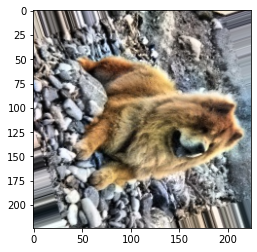

In [ ]:
plt.imshow(rotation_train.next()[0][0])

In [13]:
plot_5breeds=PlotLossesCallback()

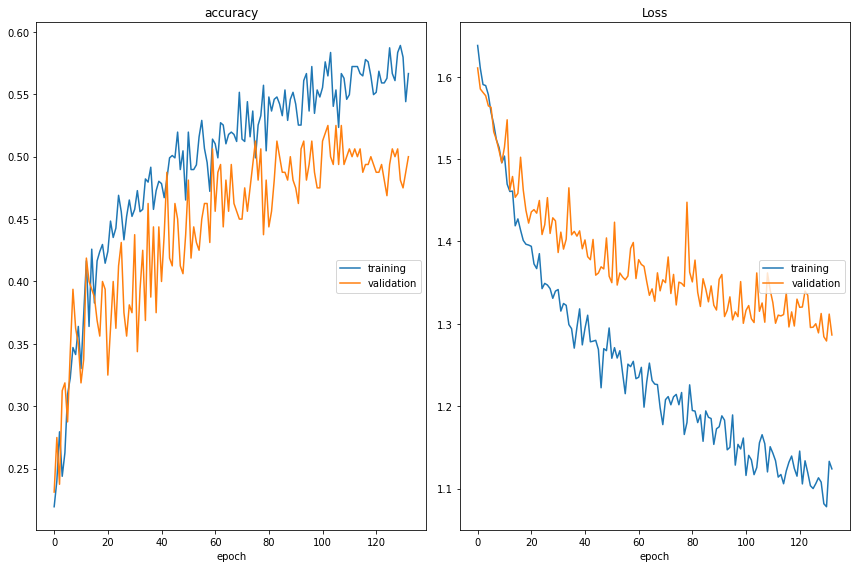

accuracy
	training         	 (min:    0.220, max:    0.589, cur:    0.567)
	validation       	 (min:    0.231, max:    0.525, cur:    0.500)
Loss
	training         	 (min:    1.078, max:    1.638, cur:    1.124)
	validation       	 (min:    1.279, max:    1.611, cur:    1.286)
Epoch 00133: early stopping


In [14]:
result_rotation=best_model.fit(rotation_train, steps_per_epoch=553//20, epochs=1000, verbose=1,
                          validation_data=aug_validation, validation_steps=aug_validation.n //20,
                          callbacks=[History(),
               ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/5_breeds/' + 'rotation_data_5_breeds', monitor='val_accuracy', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True, verbose=1),plot_5breeds
              ])

### **Mixing the augmentation techniques**

In [ ]:
combo_gen=ImageDataGenerator(rotation_range=90,width_shift_range=0.05,
                             height_shift_range=0.05,zoom_range=0.05,
                             fill_mode='nearest',cval=0.0,
                             horizontal_flip=True,rescale=1./255)

combo_train=combo_gen.flow_from_directory(training_path, target_size=(224, 224),classes=['chow', 'collie','cairn','dhole','dingo'],
                              class_mode='categorical', batch_size=20)

Found 553 images belonging to 5 classes.


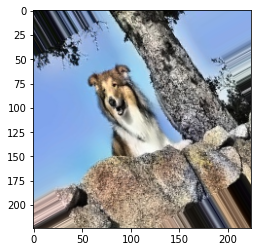

In [ ]:
plt.imshow(combo_train.next()[0][0])

In [ ]:
result_combo=best_model.fit(combo_train, steps_per_epoch=553//20, epochs=1000, verbose=1,
                          validation_data=aug_validation, validation_steps=aug_validation.n // 20,
                          callbacks=[History(),
               ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/5_breeds/' + 'combo_data_5_breeds', monitor='val_accuracy', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True, verbose=1)
              ])

Epoch 1/1000
27/27 [==============================] - 7s 260ms/step - loss: 1.1100 - accuracy: 0.5553 - val_loss: 1.2551 - val_accuracy: 0.5437

Epoch 00001: val_accuracy improved from -inf to 0.54375, saving model to /content/drive/MyDrive/Formation_Machine_Learning/P6/5_breeds/combo_data_5_breeds
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Formation_Machine_Learning/P6/5_breeds/combo_data_5_breeds/assets
Epoch 2/1000
27/27 [==============================] - 7s 255ms/step - loss: 1.0710 - accuracy: 0.5704 - val_loss: 1.2696 - val_accuracy: 0.5250

Epoch 00002: val_accuracy did not improve from 0.54375
Epoch 3/1000
27/27 [==============================] - 7s 269ms/step - loss: 1.1162 - accuracy: 0.5685 - val_loss: 1.2659 - val_accuracy: 0.5312

Epoch 00003: val_accuracy did not improve from 0.54375
Epoch 4/1000
27/27 [==============================] - 7s 256ms/step - loss: 1.0861 - accuracy: 0.5685 - val_loss: 1.3087 - val_accuracy: 0.5250

Epoch 00004: val_accuracy did n

## Evaluation - Visualization 

### Loading models

In [ ]:
model=tf.keras.models.load_model('/content/drive/MyDrive/Formation_Machine_Learning/P6/5_breeds/data_5_breeds/')
model_combo=tf.keras.models.load_model('/content/drive/MyDrive/Formation_Machine_Learning/P6/5_breeds/combo_data_5_breeds/')
model_rotation=tf.keras.models.load_model('/content/drive/MyDrive/Formation_Machine_Learning/P6/5_breeds/rotation_data_5_breeds/')
model_hflipped=tf.keras.models.load_model('/content/drive/MyDrive/Formation_Machine_Learning/P6/5_breeds/hflipped_data_5_breeds/')
model_vflipped=tf.keras.models.load_model('/content/drive/MyDrive/Formation_Machine_Learning/P6/5_breeds/vflipped_data_5_breeds/')
model_shifted=tf.keras.models.load_model('/content/drive/MyDrive/Formation_Machine_Learning/P6/5_breeds/shifted_data_5_breeds/')

### Evaluating on the test set

First we need to generate the test set using the data generator method

In [ ]:
test_gen=ImageDataGenerator(rescale=1/255)
aug_test=test_gen.flow_from_directory(test_path,target_size=(224, 224),classes=['chow', 'collie','cairn','dhole','dingo'],
                              class_mode='categorical', batch_size=20, shuffle=False)

Found 127 images belonging to 5 classes.


In [ ]:
model.evaluate(aug_test)

7/7 [==============================] - 0s 63ms/step - loss: 1.1367 - accuracy: 0.6142


[1.1367244720458984, 0.6141732335090637]

In [ ]:
model_combo.evaluate(aug_test)

7/7 [==============================] - 0s 58ms/step - loss: 1.1164 - accuracy: 0.6142


[1.116361141204834, 0.6141732335090637]

In [ ]:
model_hflipped.evaluate(aug_test)

7/7 [==============================] - 0s 58ms/step - loss: 1.1240 - accuracy: 0.5984


[1.1240482330322266, 0.5984252095222473]

In [ ]:
model_rotation.evaluate(aug_test)

7/7 [==============================] - 0s 62ms/step - loss: 1.1240 - accuracy: 0.6220


[1.1240204572677612, 0.6220472455024719]

In [ ]:
model_shifted.evaluate(aug_test)

7/7 [==============================] - 0s 59ms/step - loss: 1.1210 - accuracy: 0.5827


[1.1209874153137207, 0.5826771855354309]

In [ ]:
model_vflipped.evaluate(aug_test)

7/7 [==============================] - 0s 66ms/step - loss: 1.1518 - accuracy: 0.5906


[1.1517783403396606, 0.5905511975288391]

According to the results above: 

- among all the data augmentation techniques, only the **rotated data** gave us a slight improvment. 

- the **rotated data** gives higher accuracy and lower loss value



### Evaluating accuracy on Train/Validation sets

In [ ]:
dict_histories={'baseline':best_res, 'combo': result_combo, 'shifted': result_shifted, 'rotation': result_rotation, 'vflipped': reslt_vflipped, 'hflipped': result_hflipped}

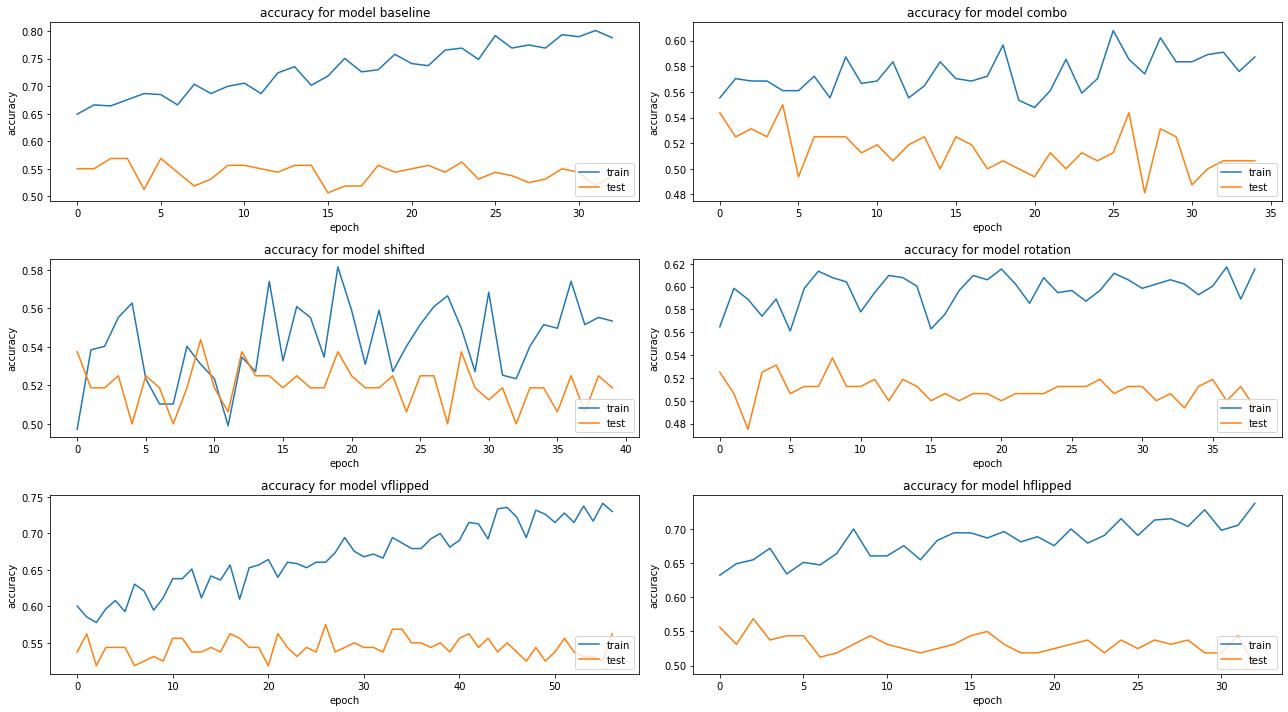

In [ ]:
fig=plt.figure(figsize=(18,10))
for i, (key, value) in enumerate(list(dict_histories.items())):
 
  fig.add_subplot(3,2,i+1)
  plt.plot(value.history['accuracy'],label='train')
  plt.plot(value.history['val_accuracy'],label='test')
  plt.title(f'accuracy for model {key}')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.tight_layout()
  plt.legend(loc='lower right')

plt.show()

from above plots we can see that: 

- we have reduced the gap of overfitting between the train and the validation sets 

- rescaled images (with no image modification) are the best in training the model but the model trained with the rotated data technique gives better validation/test accuracy 

- for that, a choice has to be made between both data augmentation techniques

### Evaluating models performances in each class

In order to see which  method is the best, we are going to look deeply in the accuracy score and inspect the performace on each class

In [ ]:
def get_accuracy(models_dict):

  #get the labels dictionnary from the test dataset
  labels=dict((u,r) for r,u in aug_test.class_indices.items())

  #set the augmented test set filenames
  filenames=[file.split('/')[0] for file in aug_test.filenames]

  # prediction and accuracy dictionnaries
  predictions_dict={}
  accuracy_dict={}

  for k,v in models_dict.items():

    score_model=v.evaluate(aug_test)
    aug_test.reset()
    scores_model=v.predict(aug_test)
    predictions_model=[labels[i] for i in np.argmax(scores_model, axis=1)]
    predictions_dict[k]=predictions_model


  for model, model_predictions in predictions_dict.items():

    accuracy={}

    for x,y in Counter(filenames).items():
      counter=0
      first_index=filenames.index(x)
      for pred in model_predictions[first_index:y+first_index]:
        if pred==x:
          counter += 1
      accuracy[x]=counter/y

    accuracy_dict[model]=accuracy


  return accuracy_dict


In [ ]:
dict_models={'baseline':model, 'combo': model_combo, 'shifted': model_shifted, 'rotation': model_rotation, 'vflipped': model_vflipped, 'hflipped': model_hflipped}

In [ ]:
accuracy_results=get_accuracy(dict_models)

7/7 [==============================] - 0s 56ms/step - loss: 1.1240 - accuracy: 0.5984


In [ ]:
accuracy_results

{'baseline': {'cairn': 0.8333333333333334,
  'chow': 0.7586206896551724,
  'collie': 0.5652173913043478,
  'dhole': 0.4090909090909091,
  'dingo': 0.391304347826087},
 'combo': {'cairn': 0.8333333333333334,
  'chow': 0.6896551724137931,
  'collie': 0.5217391304347826,
  'dhole': 0.5454545454545454,
  'dingo': 0.391304347826087},
 'hflipped': {'cairn': 0.8,
  'chow': 0.7586206896551724,
  'collie': 0.5217391304347826,
  'dhole': 0.4090909090909091,
  'dingo': 0.391304347826087},
 'rotation': {'cairn': 0.8666666666666667,
  'chow': 0.6896551724137931,
  'collie': 0.4782608695652174,
  'dhole': 0.45454545454545453,
  'dingo': 0.5217391304347826},
 'shifted': {'cairn': 0.7333333333333333,
  'chow': 0.7931034482758621,
  'collie': 0.43478260869565216,
  'dhole': 0.36363636363636365,
  'dingo': 0.4782608695652174},
 'vflipped': {'cairn': 0.5666666666666667,
  'chow': 0.7586206896551724,
  'collie': 0.5217391304347826,
  'dhole': 0.5909090909090909,
  'dingo': 0.4782608695652174}}

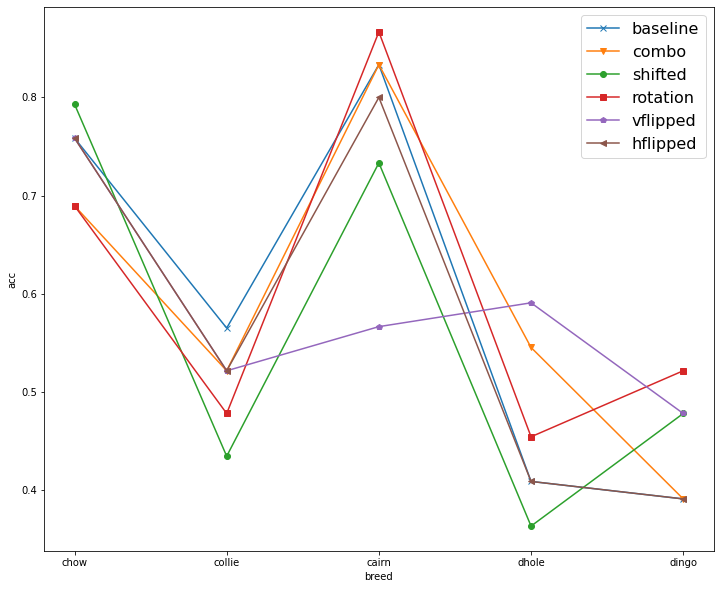

In [ ]:
markers=['x','v','o','s','p',"<"]
plt.figure(figsize=(12,10))
for (key,value),mark in zip(accuracy_results.items(),markers):
  plt.plot([breed for breed,acc in value.items()],[acc for breed,acc in value.items()],marker=mark,label=key)
  plt.legend(fontsize=16)

plt.xlabel('breed')
plt.ylabel('acc')
plt.show()

between the **rescaled data** and the **rotated data** :

- rescaled data gives better accuracy for breeds: **chow** and **collie**

- rotated data is better with the rest 

In our final choice we can go with the rotated data since its better results

# **Final Model** 

We are going to use the **rotated data** as augmentation technique, since it gave us the best results so far




For our CNN Architecture we are going to use  the following :

- **padding**: 'valid'

- **optimizer**: 'Adagrad'

- **kernel_s**: (4, 4)

- **drop_rate**: 0.3

- **activation_fn**: 'tanh'



## Testing final model

In [ ]:
final_model=tf.keras.models.load_model('/content/drive/MyDrive/Formation_Machine_Learning/P6/5_breeds/rotation_data_5_breeds/')

In [ ]:
breeds=['chow','collie','cairn','dhole','dingo']

In [ ]:
image_chow=cv2.imread('/content/drive/MyDrive/Formation_Machine_Learning/P6/data/resized_images/test_data/chow/n02112137_8212.jpg',cv2.IMREAD_UNCHANGED)

In [ ]:
image_collie=cv2.imread('/content/drive/MyDrive/Formation_Machine_Learning/P6/data/resized_images/test_data/collie/n02106030_3776.jpg',cv2.IMREAD_UNCHANGED)

In [ ]:
image_cairn=cv2.imread('/content/drive/MyDrive/Formation_Machine_Learning/P6/data/resized_images/test_data/cairn/n02096177_729.jpg',cv2.IMREAD_UNCHANGED)

In [ ]:
image_dhole=cv2.imread('/content/drive/MyDrive/Formation_Machine_Learning/P6/data/resized_images/test_data/dhole/n02115913_5392.jpg',cv2.IMREAD_UNCHANGED)

In [ ]:
image_dingo=cv2.imread('/content/drive/MyDrive/Formation_Machine_Learning/P6/data/resized_images/test_data/dingo/n02115641_9348.jpg',cv2.IMREAD_UNCHANGED)

In [ ]:
def get_prediction(img):

  labels=dict((v,k) for k,v in aug_test.class_indices.items())

  #adapt_image
  image = img.astype('float64')
  image /= 255
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

  pred_proba=final_model.predict(image)
  pred1=np.argsort(pred_proba, axis=1)[:,-2:][0][0]
  pred2=np.argsort(pred_proba, axis=1)[:,-2:][0][1]
  
  res=print(f'the prediction might be {labels[pred1]} or {labels[pred2]} in probability order')

  return res

In [ ]:
get_prediction(image_dingo)

the prediction might be cairn or collie in probability order


In [ ]:
get_prediction(image_chow)

the prediction might be cairn or collie in probability order


In [ ]:
get_prediction(image_collie)

the prediction might be cairn or collie in probability order


In [ ]:
get_prediction(image_cairn)

the prediction might be collie or cairn in probability order


In [ ]:
get_prediction(image_dhole)

the prediction might be cairn or collie in probability order
